# This file produces a benchmark test of the trained NN

In [57]:
import numpy as np
import os, subprocess, sys
import scipy.io
from scipy.linalg import solve_continuous_are
from scipy.special import softmax
from typing import Optional, Callable, Tuple, Dict, List
import time
import warnings
import json
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    warnings.warn("PyTorch not available. GPU training will not be available.")
    
from ocslc.switched_linear_mpc import SwitchedLinearMPC as SwiLin_casadi

from src.switched_linear_torch import SwiLin
from src.training import SwiLinNN

## Set environment variables

In [58]:
# Global settings
N_PHASES = 80
TIME_HORIZON = 10.0

# NN settings
N_CONTROL_INPUTS = 1
N_STATES = 3
N_NN_INPUTS = 3
N_NN_OUTPUTS = N_PHASES * (N_CONTROL_INPUTS + 1)  # +1 for the mode

# Casadi settings
MULTIPLE_SHOOTING = True
INTEGRATOR = 'exp'
HYBRID = False
PLOT = 'display'

## Load the trained Neural Network

In [59]:
dtype = np.float32

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define neural network architecture
network = SwiLinNN(
    layer_sizes=[N_NN_INPUTS, 50, 50, N_NN_OUTPUTS],
    n_phases=N_PHASES,
)
network.to(device)

# Load pre-trained model weights
checkpoint_path = os.path.abspath(os.path.join('..', 'models', 'pannocchia_50_50_torch_20251216_145750.pt'))
network.load_state_dict(torch.load(checkpoint_path, map_location=device))
# Set model to evaluation mode
network.eval() 

SwiLinNN(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=160, bias=True)
  )
)

## Set initial state

In [60]:
x0 = np.array([1.3440, -4.5850, 5.6470])
# x0 = np.array([2, -1, 5])

## Set up the optimization problem in Casadi

In [61]:
model = {
    'A': [np.array([[-0.1, 0, 0], [0, -2, -6.25], [0, 4, 0]])],
    'B': [np.array([[0.25], [2], [0]])],
}

n_states = model['A'][0].shape[0]
n_inputs = model['B'][0].shape[1]

# x0 = np.array([1.3440, -4.5850, 5.6470])

swi_lin_casadi = SwiLin_casadi(
    model, 
    n_phases=N_PHASES, 
    time_horizon=TIME_HORIZON, 
    auto=False,
    x0=x0,
    multiple_shooting=MULTIPLE_SHOOTING,
    propagation=INTEGRATOR,
    inspect = False,
    hybrid=HYBRID,
    plot=PLOT,
)

Q = 1. * np.eye(n_states)
R = 0.1 * np.eye(n_inputs)
# Solve the Algebraic Riccati Equation
P = np.array(solve_continuous_are(model['A'][0], model['B'][0], Q, R))

swi_lin_casadi.precompute_matrices(x0, Q, R, P)

# loaded_data = scipy.io.loadmat('optimal_results_hybrid.mat')
# fixed_states = loaded_data['trajectory'][0]
# fixed_inputs = loaded_data['controls'][0]

states_lb = np.array([-100, -100, -100])
states_ub = np.array([100, 100, 100]) 

swi_lin_casadi.set_bounds(
    -1, 
    1, 
    states_lb, 
    states_ub, 
    # inspect_inputs=fixed_inputs,
    # inspect_states=fixed_states,
)

if swi_lin_casadi.multiple_shooting:
    swi_lin_casadi.multiple_shooting_constraints(x0)

swi_lin_casadi.set_cost_function(Q, R, x0, P)

# Set the initial guess  
exp_dist = 0.99**np.arange(80)
phase_durations = exp_dist * TIME_HORIZON / np.sum(exp_dist)

swi_lin_casadi.set_initial_guess(
    x0, 
    # initial_phases_duration=phase_durations
)

swi_lin_casadi.create_solver('ipopt')

## Solve NN

In [62]:
start = time.time()
with torch.no_grad():
    # Convert state to tensor
    x_tensor = torch.tensor(x0, dtype=network.sys.dtype, device=device)  # shape (1, n_states)
    output = network(x_tensor).flatten()
    output = output.cpu().numpy() # shape (n_phases * n_inputs + n_phases,)

# Extract phase and control inputs
n_control_outputs = N_PHASES * N_CONTROL_INPUTS
pred_u = output[:n_control_outputs] # shape (n_phases * n_inputs,)
pred_delta_raw = output[n_control_outputs:]
last = pred_delta_raw[-1]
pred_delta_raw_traslated = pred_delta_raw - last  # shape (n_phases,)

# Apply softmax and scale deltas
delta_normalized = softmax(pred_delta_raw_traslated, axis=-1)
deltas = delta_normalized * TIME_HORIZON # shape (n_phases,)

# Clip controls using tanh-based soft clipping to preserve gradients
u_min = -1.0  # Define your lower bound
u_max = 1.0   # Define your upper bound
u_center = (u_max + u_min) / 2.0
u_range = (u_max - u_min) / 2.0
# Soft clipping: maps (-inf, inf) to (u_min, u_max) smoothly
u = u_center + u_range * np.tanh(pred_u)

end = time.time()
NN_computation_time = end - start
# print(f"Computation time: {NN_computation_time} seconds")

## Compute cost function value

In [63]:
swi_lin = SwiLin(N_PHASES, N_STATES, N_CONTROL_INPUTS, TIME_HORIZON, auto=False, device=device)
swi_lin.load_model(model)
swi_lin.load_weights(Q, R, P)

# Ensure u, deltas, x0 are numpy arrays and have expected shapes
u = np.asarray(u)
deltas = np.asarray(deltas)
x0 = np.asarray(x0)

# Reshape control outputs into (N_PHASES, N_CONTROL_INPUTS)
if u.ndim == 1:
    if u.size != N_PHASES * N_CONTROL_INPUTS:
        raise ValueError(f"Unexpected control vector length: {u.size}, expected {N_PHASES * N_CONTROL_INPUTS}")
    u_reshaped = u.reshape(N_PHASES, N_CONTROL_INPUTS)
elif u.ndim == 2 and u.shape[0] == 1:
    u_reshaped = u.reshape(N_PHASES, N_CONTROL_INPUTS)
else:
    # Try to reshape; will raise if incompatible
    u_reshaped = u.reshape(N_PHASES, N_CONTROL_INPUTS)

# Ensure deltas is a 1D vector of length N_PHASES
if deltas.ndim > 1:
    deltas_squeezed = deltas.reshape(-1)
else:
    deltas_squeezed = deltas
if deltas_squeezed.size != N_PHASES:
    raise ValueError(f"Unexpected deltas length: {deltas_squeezed.size}, expected {N_PHASES}")

# Ensure x0 is a 1D state vector
x0_squeezed = x0.reshape(-1)

nn_opt_cost = swi_lin.cost_function(u_reshaped, deltas_squeezed, x0_squeezed)

## Solve Casadi optimization

In [64]:
start = time.time()
    
inputs_opt, deltas_opt, states_opt = swi_lin_casadi.solve()
casadi_opt_cost = swi_lin_casadi.opt_cost

casadi_solving_time = time.time() - start

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 276

                                   (scaled)                 (unscaled)
Objective...............:   1.2721964330794947e+01    1.2721964330794947e+01
Dual infeasibility......:   4.6656401159692342e-14    4.6656401159692342e-14
Constraint violation....:   8.8817841970012523e-16    8.8817841970012523e-16
Variable bound violation:   6.4125091252487956e-09    6.4125091252487956e-09
Complementar

## Print results

In [65]:
# Print results
# Helper to convert scalar-like values (numpy, python float, or torch tensor on any device) to Python float
def _to_scalar_float(val):
    try:
        import torch
        is_torch = 'torch' in globals() and TORCH_AVAILABLE
    except Exception:
        is_torch = False

    if is_torch and isinstance(val, torch.Tensor):
        return float(val.detach().cpu().item())

    arr = np.asarray(val)
    if arr.size == 1:
        return float(arr.item())
    # fallback: take first element
    return float(arr.reshape(-1)[0])

nn_opt_cost_val = _to_scalar_float(nn_opt_cost)
casadi_opt_cost_val = _to_scalar_float(casadi_opt_cost)

print("OPTIMIZATION RESULTS COMPARISON")
print("=" * 60)
print(f"\n{'Metric':<30} {'NN-based':<15} {'CasADi':<15}")
print("-" * 60)
print(f"{'Optimal Cost':<30} {nn_opt_cost_val:<15.6f} {casadi_opt_cost_val:<15.6f}")
print(f"{'Computation Time (s)':<30} {NN_computation_time:<15.6f} {casadi_solving_time:<15.6f}")
# Protect division by zero for speedup
if NN_computation_time != 0:
    speedup = casadi_solving_time / NN_computation_time
else:
    speedup = float('inf')
print(f"{'Speedup Factor':<30} {speedup:<15.2f}x")

# Cost difference percentage, protect division by zero
if casadi_opt_cost_val != 0:
    cost_diff_pct = abs(nn_opt_cost_val - casadi_opt_cost_val) / abs(casadi_opt_cost_val) * 100
else:
    cost_diff_pct = float('inf')
print(f"{'Cost Difference (%)':<30} {cost_diff_pct:<15.2f}%")
print("=" * 60)

OPTIMIZATION RESULTS COMPARISON

Metric                         NN-based        CasADi         
------------------------------------------------------------
Optimal Cost                   12.878408       12.721964      
Computation Time (s)           0.000918        0.532031       
Speedup Factor                 579.46         x
Cost Difference (%)            1.23           %


## Batch Simulation: Multiple Initial States

Run simulations for a range of different initial states to compare NN performance vs. CasADi optimization.

In [66]:
# Generate a batch of random initial states
np.random.seed(42)  # For reproducibility
n_samples = 20

# Generate random initial states within reasonable bounds
x0_batch = []
for _ in range(n_samples):
    x0_sample = np.random.uniform(low=[-5, -10, -10], high=[5, 10, 10], size=3)
    x0_batch.append(x0_sample)

x0_batch = np.array(x0_batch)
print(f"Generated {n_samples} random initial states")
print(f"Sample x0 values:\n{x0_batch[:3]}")

Generated 20 random initial states
Sample x0 values:
[[-1.25459881  9.01428613  4.63987884]
 [ 0.98658484 -6.87962719 -6.88010959]
 [-4.41916388  7.32352292  2.02230023]]


In [67]:
# Run batch simulations
results = {
    'x0': [],
    'nn_cost': [],
    'casadi_cost': [],
    'nn_time': [],
    'casadi_time': [],
    'cost_diff_pct': [],
    'speedup': []
}

print("Running batch simulations...")
print("=" * 80)

for i, x0_sample in enumerate(x0_batch):
    print(f"\nSample {i+1}/{n_samples}: x0 = [{x0_sample[0]:.3f}, {x0_sample[1]:.3f}, {x0_sample[2]:.3f}]")
    
    # ===== Neural Network Solution =====
    start_nn = time.time()
    with torch.no_grad():
        x_tensor = torch.tensor(x0_sample, dtype=network.sys.dtype, device=device)
        output = network(x_tensor).flatten()
        output = output.cpu().numpy()
    
    # Extract and process NN outputs
    n_control_outputs = N_PHASES * N_CONTROL_INPUTS
    pred_u = output[:n_control_outputs]
    pred_delta_raw = output[n_control_outputs:]
    last = pred_delta_raw[-1]
    pred_delta_raw_traslated = pred_delta_raw - last
    
    delta_normalized = softmax(pred_delta_raw_traslated, axis=-1)
    deltas_nn = delta_normalized * TIME_HORIZON
    
    u_min, u_max = -1.0, 1.0
    u_center = (u_max + u_min) / 2.0
    u_range = (u_max - u_min) / 2.0
    u_nn = u_center + u_range * np.tanh(pred_u)
    
    nn_time = time.time() - start_nn
    
    # Compute NN cost
    u_reshaped = u_nn.reshape(N_PHASES, N_CONTROL_INPUTS)
    nn_cost = swi_lin.cost_function(u_reshaped, deltas_nn, x0_sample)
    nn_cost_val = _to_scalar_float(nn_cost)
    
    # ===== CasADi Optimization =====
    # Update CasADi problem with new x0
    swi_lin_casadi.precompute_matrices(x0_sample, Q, R, P)
    if swi_lin_casadi.multiple_shooting:
        swi_lin_casadi.multiple_shooting_constraints(x0_sample, update=True)
    swi_lin_casadi.set_cost_function(Q, R, x0_sample, P)
    swi_lin_casadi.set_initial_guess(x0_sample)
    
    start_casadi = time.time()
    inputs_opt, deltas_opt, states_opt = swi_lin_casadi.solve()
    casadi_cost_val = float(swi_lin_casadi.opt_cost)
    casadi_time = time.time() - start_casadi
    
    # Compute metrics
    cost_diff = abs(nn_cost_val - casadi_cost_val) / abs(casadi_cost_val) * 100 if casadi_cost_val != 0 else float('inf')
    speedup_factor = casadi_time / nn_time if nn_time > 0 else float('inf')
    
    # Store results
    results['x0'].append(x0_sample)
    results['nn_cost'].append(nn_cost_val)
    results['casadi_cost'].append(casadi_cost_val)
    results['nn_time'].append(nn_time)
    results['casadi_time'].append(casadi_time)
    results['cost_diff_pct'].append(cost_diff)
    results['speedup'].append(speedup_factor)
    
    print(f"  NN:     Cost = {nn_cost_val:10.6f}, Time = {nn_time:8.6f}s")
    print(f"  CasADi: Cost = {casadi_cost_val:10.6f}, Time = {casadi_time:8.6f}s")
    print(f"  Speedup: {speedup_factor:.2f}x, Cost Diff: {cost_diff:.2f}%")

print("\n" + "=" * 80)
print("Batch simulation completed!")

Running batch simulations...

Sample 1/20: x0 = [-1.255, 9.014, 4.640]
Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality const

/tmp/ipykernel_124249/694408060.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  casadi_cost_val = float(swi_lin_casadi.opt_cost)


Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 325

                                   (scaled)                 (unscaled)
Objective...............:   2.6511512753535659e+01    2.6511512753535659e+01
Dual infeasibility......:   1.2915318124092520e-10    1.2915318124092520e-10
Constraint violation....:   1.4373224832553433e-13    1.4373224832553433e-13
Variable bound violation:   6.1804121820330238e-09    6.1804121820330238e-09
Complementar

## Summary Statistics

In [68]:
# Compute summary statistics
nn_costs = np.array(results['nn_cost'])
casadi_costs = np.array(results['casadi_cost'])
nn_times = np.array(results['nn_time'])
casadi_times = np.array(results['casadi_time'])
cost_diffs = np.array(results['cost_diff_pct'])
speedups = np.array(results['speedup'])

# Filter outliers based on cost threshold
cost_threshold = 50.0  # Adjust this threshold as needed
valid_mask = (nn_costs < cost_threshold) & (casadi_costs < cost_threshold) & (casadi_costs > 0)
n_filtered = np.sum(~valid_mask)

if n_filtered > 0:
    print(f"Filtering out {n_filtered} outliers with cost > {cost_threshold}")
    nn_costs_filtered = nn_costs[valid_mask]
    casadi_costs_filtered = casadi_costs[valid_mask]
    nn_times_filtered = nn_times[valid_mask]
    casadi_times_filtered = casadi_times[valid_mask]
    cost_diffs_filtered = cost_diffs[valid_mask]
    speedups_filtered = speedups[valid_mask]
else:
    nn_costs_filtered = nn_costs
    casadi_costs_filtered = casadi_costs
    nn_times_filtered = nn_times
    casadi_times_filtered = casadi_times
    cost_diffs_filtered = cost_diffs
    speedups_filtered = speedups

print("BATCH SIMULATION SUMMARY")
print("=" * 80)
print(f"Total samples: {len(nn_costs)}, Valid samples: {len(nn_costs_filtered)}, Outliers removed: {n_filtered}")
print("-" * 80)
print(f"{'Metric':<35} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 80)
print(f"{'NN Cost':<35} {nn_costs_filtered.mean():>11.6f} {nn_costs_filtered.std():>11.6f} {nn_costs_filtered.min():>11.6f} {nn_costs_filtered.max():>11.6f}")
print(f"{'CasADi Cost':<35} {casadi_costs_filtered.mean():>11.6f} {casadi_costs_filtered.std():>11.6f} {casadi_costs_filtered.min():>11.6f} {casadi_costs_filtered.max():>11.6f}")
print(f"{'NN Time (s)':<35} {nn_times_filtered.mean():>11.6f} {nn_times_filtered.std():>11.6f} {nn_times_filtered.min():>11.6f} {nn_times_filtered.max():>11.6f}")
print(f"{'CasADi Time (s)':<35} {casadi_times_filtered.mean():>11.6f} {casadi_times_filtered.std():>11.6f} {casadi_times_filtered.min():>11.6f} {casadi_times_filtered.max():>11.6f}")
print(f"{'Speedup Factor':<35} {speedups_filtered.mean():>11.2f} {speedups_filtered.std():>11.2f} {speedups_filtered.min():>11.2f} {speedups_filtered.max():>11.2f}")
print(f"{'Cost Difference (%)':<35} {cost_diffs_filtered.mean():>11.2f} {cost_diffs_filtered.std():>11.2f} {cost_diffs_filtered.min():>11.2f} {cost_diffs_filtered.max():>11.2f}")
print("=" * 80)
print(f"\nTotal NN time:     {nn_times_filtered.sum():.4f}s")
print(f"Total CasADi time: {casadi_times_filtered.sum():.4f}s")
print(f"Overall speedup:   {casadi_times_filtered.sum()/nn_times_filtered.sum():.2f}x")

Filtering out 2 outliers with cost > 50.0
BATCH SIMULATION SUMMARY
Total samples: 20, Valid samples: 18, Outliers removed: 2
--------------------------------------------------------------------------------
Metric                              Mean         Std          Min          Max         
--------------------------------------------------------------------------------
NN Cost                               26.765618   13.395122    3.913540   48.648659
CasADi Cost                           26.520697   13.493184    3.584545   48.463924
NN Time (s)                            0.000543    0.000131    0.000480    0.001078
CasADi Time (s)                        0.850257    0.663046    0.242585    2.306371
Speedup Factor                          1657.62     1374.97      433.65     4800.80
Cost Difference (%)                        2.09        2.90        0.20        9.18

Total NN time:     0.0098s
Total CasADi time: 15.3046s
Overall speedup:   1566.05x


## Visualization: Batch Results

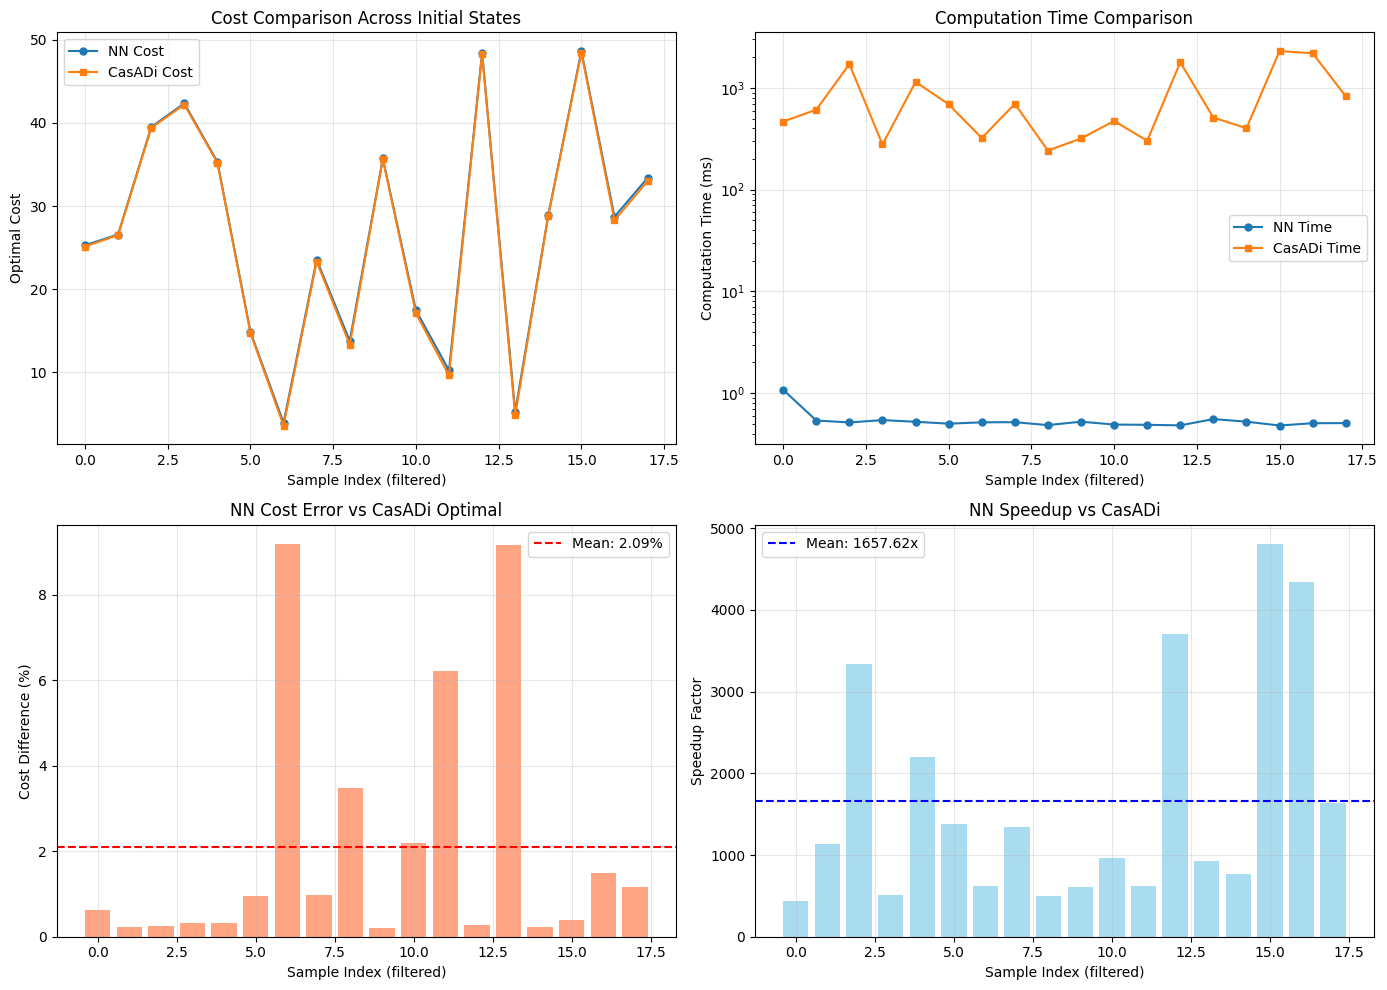

Plots saved to ../images/batch_benchmark_results.png


In [75]:
# Create visualization plots (using filtered data)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Use filtered data for plotting
sample_indices_filtered = np.arange(len(nn_costs_filtered))

# Plot 1: Cost Comparison
ax1 = axes[0, 0]
ax1.plot(sample_indices_filtered, nn_costs_filtered, 'o-', label='NN Cost', markersize=5, linewidth=1.5)
ax1.plot(sample_indices_filtered, casadi_costs_filtered, 's-', label='CasADi Cost', markersize=5, linewidth=1.5)
ax1.set_xlabel('Sample Index (filtered)')
ax1.set_ylabel('Optimal Cost')
ax1.set_title(f'Cost Comparison Across Initial States')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Computation Time Comparison
ax2 = axes[0, 1]
ax2.plot(sample_indices_filtered, nn_times_filtered * 1000, 'o-', label='NN Time', markersize=5, linewidth=1.5)
ax2.plot(sample_indices_filtered, casadi_times_filtered * 1000, 's-', label='CasADi Time', markersize=5, linewidth=1.5)
ax2.set_xlabel('Sample Index (filtered)')
ax2.set_ylabel('Computation Time (ms)')
ax2.set_title('Computation Time Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Cost Difference Percentage
ax3 = axes[1, 0]
ax3.bar(sample_indices_filtered, cost_diffs_filtered, alpha=0.7, color='coral')
ax3.axhline(y=cost_diffs_filtered.mean(), color='red', linestyle='--', label=f'Mean: {cost_diffs_filtered.mean():.2f}%')
ax3.set_xlabel('Sample Index (filtered)')
ax3.set_ylabel('Cost Difference (%)')
ax3.set_title('NN Cost Error vs CasADi Optimal')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Speedup Factor
ax4 = axes[1, 1]
ax4.bar(sample_indices_filtered, speedups_filtered, alpha=0.7, color='skyblue')
ax4.axhline(y=speedups_filtered.mean(), color='blue', linestyle='--', label=f'Mean: {speedups_filtered.mean():.2f}x')
ax4.set_xlabel('Sample Index (filtered)')
ax4.set_ylabel('Speedup Factor')
ax4.set_title('NN Speedup vs CasADi')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/batch_benchmark_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved to ../images/batch_benchmark_results.png")

## Batch Simulation: Varying Time Horizon

Run simulations with different time horizons, keeping the initial state fixed.

In [70]:
# Generate a batch of different time horizons
# Keep x0 fixed from the original setting
x0_fixed = np.array([1.3440, -4.5850, 5.6470])

# Create a range of time horizons
n_horizons = 20
time_horizons = np.linspace(1.0, 20.0, n_horizons)

print(f"Testing {n_horizons} different time horizons")
print(f"Time horizon range: {time_horizons[0]:.2f}s to {time_horizons[-1]:.2f}s")
print(f"Fixed initial state: x0 = {x0_fixed}")

Testing 20 different time horizons
Time horizon range: 1.00s to 20.00s
Fixed initial state: x0 = [ 1.344 -4.585  5.647]


In [71]:
# Run batch simulations with varying time horizon
results_horizon = {
    'time_horizon': [],
    'nn_cost': [],
    'casadi_cost': [],
    'nn_time': [],
    'casadi_time': [],
    'cost_diff_pct': [],
    'speedup': []
}

print("Running batch simulations with varying time horizons...")
print("=" * 80)

for i, T_h in enumerate(time_horizons):
    print(f"\nHorizon {i+1}/{n_horizons}: T = {T_h:.2f}s")
    
    # ===== Neural Network Solution =====
    # Create new network instance with this time horizon
    network_T = SwiLinNN(
        layer_sizes=[N_NN_INPUTS, 50, 50, N_NN_OUTPUTS],
        n_phases=N_PHASES,
    )
    network_T.to(device)
    # Manually set the time horizon
    network_T.sys.time_horizon = T_h
    
    # Load pre-trained model weights
    checkpoint_path = os.path.abspath(os.path.join('..', 'models', 'pannocchia_50_50_torch_20251216_145750.pt'))
    network_T.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    start_nn = time.time()
    with torch.no_grad():
        x_tensor = torch.tensor(x0_fixed, dtype=network_T.sys.dtype, device=device)
        output = network_T(x_tensor).flatten()
        output = output.cpu().numpy()
    
    # Extract and process NN outputs
    n_control_outputs = N_PHASES * N_CONTROL_INPUTS
    pred_u = output[:n_control_outputs]
    pred_delta_raw = output[n_control_outputs:]
    last = pred_delta_raw[-1]
    pred_delta_raw_traslated = pred_delta_raw - last
    
    delta_normalized = softmax(pred_delta_raw_traslated, axis=-1)
    deltas_nn = delta_normalized * T_h  # Scale by current horizon
    
    u_min, u_max = -1.0, 1.0
    u_center = (u_max + u_min) / 2.0
    u_range = (u_max - u_min) / 2.0
    u_nn = u_center + u_range * np.tanh(pred_u)
    
    nn_time = time.time() - start_nn
    
    # Compute NN cost with this horizon
    swi_lin_T = SwiLin(N_PHASES, N_STATES, N_CONTROL_INPUTS, T_h, auto=False, device=device)
    swi_lin_T.load_model(model)
    swi_lin_T.load_weights(Q, R, P)
    
    u_reshaped = u_nn.reshape(N_PHASES, N_CONTROL_INPUTS)
    nn_cost = swi_lin_T.cost_function(u_reshaped, deltas_nn, x0_fixed)
    nn_cost_val = _to_scalar_float(nn_cost)
    
    # ===== CasADi Optimization =====
    # Create new CasADi problem with this time horizon
    swi_lin_casadi_T = SwiLin_casadi(
        model, 
        n_phases=N_PHASES, 
        time_horizon=T_h,
        auto=False,
        x0=x0_fixed,
        multiple_shooting=MULTIPLE_SHOOTING,
        propagation=INTEGRATOR,
        inspect=False,
        hybrid=HYBRID,
        plot=PLOT,
    )
    
    swi_lin_casadi_T.precompute_matrices(x0_fixed, Q, R, P)
    swi_lin_casadi_T.set_bounds(-1, 1, states_lb, states_ub)
    
    if swi_lin_casadi_T.multiple_shooting:
        swi_lin_casadi_T.multiple_shooting_constraints(x0_fixed)
    
    swi_lin_casadi_T.set_cost_function(Q, R, x0_fixed, P)
    swi_lin_casadi_T.set_initial_guess(x0_fixed)
    swi_lin_casadi_T.create_solver('ipopt')
    
    start_casadi = time.time()
    inputs_opt, deltas_opt, states_opt = swi_lin_casadi_T.solve()
    casadi_cost_val = float(swi_lin_casadi_T.opt_cost)
    casadi_time = time.time() - start_casadi
    
    # Compute metrics
    cost_diff = abs(nn_cost_val - casadi_cost_val) / abs(casadi_cost_val) * 100 if casadi_cost_val != 0 else float('inf')
    speedup_factor = casadi_time / nn_time if nn_time > 0 else float('inf')
    
    # Store results
    results_horizon['time_horizon'].append(T_h)
    results_horizon['nn_cost'].append(nn_cost_val)
    results_horizon['casadi_cost'].append(casadi_cost_val)
    results_horizon['nn_time'].append(nn_time)
    results_horizon['casadi_time'].append(casadi_time)
    results_horizon['cost_diff_pct'].append(cost_diff)
    results_horizon['speedup'].append(speedup_factor)
    
    print(f"  NN:     Cost = {nn_cost_val:10.6f}, Time = {nn_time:8.6f}s")
    print(f"  CasADi: Cost = {casadi_cost_val:10.6f}, Time = {casadi_time:8.6f}s")
    print(f"  Speedup: {speedup_factor:.2f}x, Cost Diff: {cost_diff:.2f}%")

print("\n" + "=" * 80)
print("Horizon batch simulation completed!")

Running batch simulations with varying time horizons...

Horizon 1/20: T = 1.00s
Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequa

/tmp/ipykernel_124249/2789784728.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  casadi_cost_val = float(swi_lin_casadi_T.opt_cost)


Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      241
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 381

                                   (scaled)                 (unscaled)
Objective...............:   1.2664260367683202e+01    1.2664260367683202e+01
Dual infeasibility......:   8.6372850602797198e-09    8.6372850602797198e-09
Constraint violation....:   9.7982733038293190e-11    9.7982733038293190e-11
Variable bound violation:   4.7349337907477436e-09    4.7349337907477436e-09
Complementar

## Summary Statistics: Time Horizon Variation

In [72]:
# Compute summary statistics for horizon variation
horizons = np.array(results_horizon['time_horizon'])
nn_costs_h = np.array(results_horizon['nn_cost'])
casadi_costs_h = np.array(results_horizon['casadi_cost'])
nn_times_h = np.array(results_horizon['nn_time'])
casadi_times_h = np.array(results_horizon['casadi_time'])
cost_diffs_h = np.array(results_horizon['cost_diff_pct'])
speedups_h = np.array(results_horizon['speedup'])

# Filter outliers based on cost threshold
cost_threshold_h = 50.0  # Adjust this threshold as needed
valid_mask_h = (nn_costs_h < cost_threshold_h) & (casadi_costs_h < cost_threshold_h) & (casadi_costs_h > 0)
n_filtered_h = np.sum(~valid_mask_h)

if n_filtered_h > 0:
    print(f"Filtering out {n_filtered_h} outliers with cost > {cost_threshold_h}")
    horizons_filtered = horizons[valid_mask_h]
    nn_costs_h_filtered = nn_costs_h[valid_mask_h]
    casadi_costs_h_filtered = casadi_costs_h[valid_mask_h]
    nn_times_h_filtered = nn_times_h[valid_mask_h]
    casadi_times_h_filtered = casadi_times_h[valid_mask_h]
    cost_diffs_h_filtered = cost_diffs_h[valid_mask_h]
    speedups_h_filtered = speedups_h[valid_mask_h]
else:
    horizons_filtered = horizons
    nn_costs_h_filtered = nn_costs_h
    casadi_costs_h_filtered = casadi_costs_h
    nn_times_h_filtered = nn_times_h
    casadi_times_h_filtered = casadi_times_h
    cost_diffs_h_filtered = cost_diffs_h
    speedups_h_filtered = speedups_h

print("BATCH SIMULATION SUMMARY - TIME HORIZON VARIATION")
print("=" * 80)
print(f"Total horizons: {len(nn_costs_h)}, Valid horizons: {len(nn_costs_h_filtered)}, Outliers removed: {n_filtered_h}")
print("-" * 80)
print(f"{'Metric':<35} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 80)
print(f"{'NN Cost':<35} {nn_costs_h_filtered.mean():>11.6f} {nn_costs_h_filtered.std():>11.6f} {nn_costs_h_filtered.min():>11.6f} {nn_costs_h_filtered.max():>11.6f}")
print(f"{'CasADi Cost':<35} {casadi_costs_h_filtered.mean():>11.6f} {casadi_costs_h_filtered.std():>11.6f} {casadi_costs_h_filtered.min():>11.6f} {casadi_costs_h_filtered.max():>11.6f}")
print(f"{'NN Time (s)':<35} {nn_times_h_filtered.mean():>11.6f} {nn_times_h_filtered.std():>11.6f} {nn_times_h_filtered.min():>11.6f} {nn_times_h_filtered.max():>11.6f}")
print(f"{'CasADi Time (s)':<35} {casadi_times_h_filtered.mean():>11.6f} {casadi_times_h_filtered.std():>11.6f} {casadi_times_h_filtered.min():>11.6f} {casadi_times_h_filtered.max():>11.6f}")
print(f"{'Speedup Factor':<35} {speedups_h_filtered.mean():>11.2f} {speedups_h_filtered.std():>11.2f} {speedups_h_filtered.min():>11.2f} {speedups_h_filtered.max():>11.2f}")
print(f"{'Cost Difference (%)':<35} {cost_diffs_h_filtered.mean():>11.2f} {cost_diffs_h_filtered.std():>11.2f} {cost_diffs_h_filtered.min():>11.2f} {cost_diffs_h_filtered.max():>11.2f}")
print("=" * 80)
print(f"\nTotal NN time:     {nn_times_h_filtered.sum():.4f}s")
print(f"Total CasADi time: {casadi_times_h_filtered.sum():.4f}s")
print(f"Overall speedup:   {casadi_times_h_filtered.sum()/nn_times_h_filtered.sum():.2f}x")

Filtering out 2 outliers with cost > 50.0
BATCH SIMULATION SUMMARY - TIME HORIZON VARIATION
Total horizons: 20, Valid horizons: 18, Outliers removed: 2
--------------------------------------------------------------------------------
Metric                              Mean         Std          Min          Max         
--------------------------------------------------------------------------------
NN Cost                               14.719349    1.291514   12.878408   17.550577
CasADi Cost                           12.698607    0.086178   12.347625   12.725764
NN Time (s)                            0.000268    0.000039    0.000237    0.000407
CasADi Time (s)                        1.203546    1.345912    0.146831    4.610250
Speedup Factor                          4657.14     5498.96      553.33    19259.75
Cost Difference (%)                       15.92       10.22        1.23       37.91

Total NN time:     0.0048s
Total CasADi time: 21.6638s
Overall speedup:   4498.03x


## Visualization: Time Horizon Results

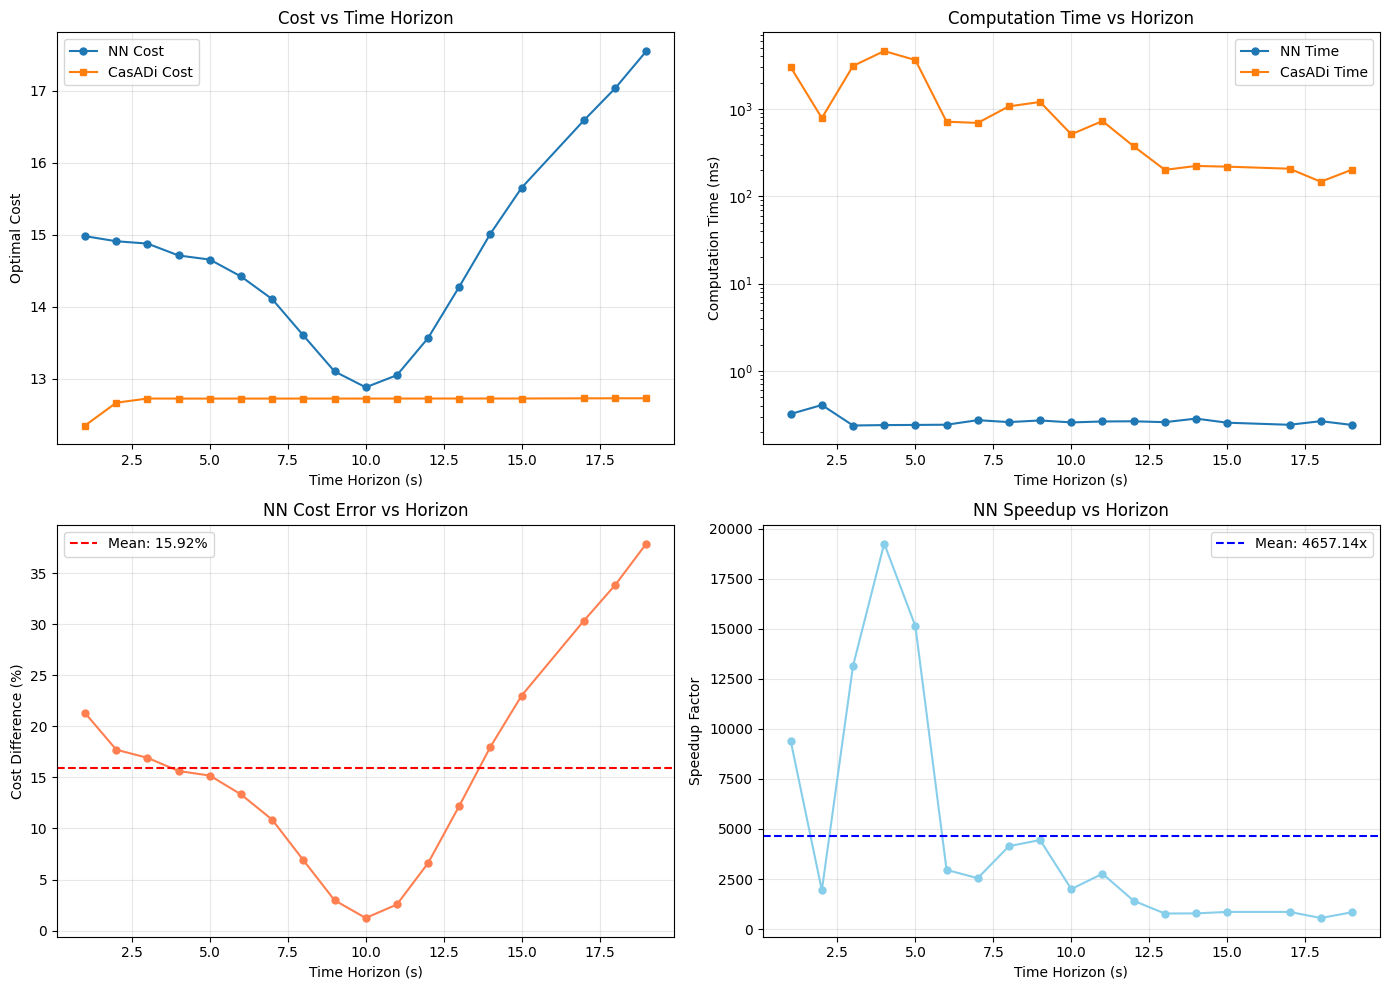

Plots saved to ../images/batch_benchmark_horizon_results.png


In [74]:
# Create visualization plots for time horizon variation (using filtered data)
fig_h, axes_h = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cost vs Time Horizon
ax1 = axes_h[0, 0]
ax1.plot(horizons_filtered, nn_costs_h_filtered, 'o-', label='NN Cost', markersize=5, linewidth=1.5)
ax1.plot(horizons_filtered, casadi_costs_h_filtered, 's-', label='CasADi Cost', markersize=5, linewidth=1.5)
ax1.set_xlabel('Time Horizon (s)')
ax1.set_ylabel('Optimal Cost')
ax1.set_title(f'Cost vs Time Horizon')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Computation Time vs Time Horizon
ax2 = axes_h[0, 1]
ax2.plot(horizons_filtered, nn_times_h_filtered * 1000, 'o-', label='NN Time', markersize=5, linewidth=1.5)
ax2.plot(horizons_filtered, casadi_times_h_filtered * 1000, 's-', label='CasADi Time', markersize=5, linewidth=1.5)
ax2.set_xlabel('Time Horizon (s)')
ax2.set_ylabel('Computation Time (ms)')
ax2.set_title('Computation Time vs Horizon')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Cost Difference Percentage vs Horizon
ax3 = axes_h[1, 0]
ax3.plot(horizons_filtered, cost_diffs_h_filtered, 'o-', color='coral', markersize=5, linewidth=1.5)
ax3.axhline(y=cost_diffs_h_filtered.mean(), color='red', linestyle='--', label=f'Mean: {cost_diffs_h_filtered.mean():.2f}%')
ax3.set_xlabel('Time Horizon (s)')
ax3.set_ylabel('Cost Difference (%)')
ax3.set_title('NN Cost Error vs Horizon')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Speedup Factor vs Horizon
ax4 = axes_h[1, 1]
ax4.plot(horizons_filtered, speedups_h_filtered, 'o-', color='skyblue', markersize=5, linewidth=1.5)
ax4.axhline(y=speedups_h_filtered.mean(), color='blue', linestyle='--', label=f'Mean: {speedups_h_filtered.mean():.2f}x')
ax4.set_xlabel('Time Horizon (s)')
ax4.set_ylabel('Speedup Factor')
ax4.set_title('NN Speedup vs Horizon')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/batch_benchmark_horizon_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved to ../images/batch_benchmark_horizon_results.png")